In [1]:
#ライブラリ
from os.path import join
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
from crabnet.crabnet_ import CrabNet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import (
    GroupKFold,
    GroupShuffleSplit,
)

/workspaces/mat2vec_codespace/.venv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#テストモデルでのデータ数は1000程度であったので今回のデータもいったん1000にしてやる

In [7]:
X = pd.read_csv("/workspaces/mat2vec_codespace/main_code/final_SC_X_data.csv")
print(X.info())
X = X.sample(frac=1, random_state=42).reset_index(drop=True)

X = X[:4000]

y = X["Tc"]
X = X.drop(columns=["Tc"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18047 entries, 0 to 18046
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   formula  18047 non-null  object 
 1   Tc       18047 non-null  float64
dtypes: float64(1), object(1)
memory usage: 282.1+ KB
None


In [8]:
# %% K-fold cross-validation
ss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
cv = GroupKFold()
cvtype = "gcv"

groups = X["formula"]


trainval_idx, test_idx = list(ss.split(X, y, groups=groups))[0]

In [9]:
X_test, y_test = X.iloc[test_idx, :], y[test_idx]
X, y = X.iloc[trainval_idx, :], y.iloc[trainval_idx]

subgroups = X["formula"]

crabnet_dfs = []

In [10]:
for train_index, test_index in cv.split(X, y, subgroups):#上記のcvをしたそれぞれのデータセットのペアごとに処理を実行
    X_train, X_val = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    train_df = pd.DataFrame(
        {"formula": X_train["formula"], "target": y_train}
    )
    val_df = pd.DataFrame(
        {"formula": X_val["formula"], "target": y_val}
    )
    
    display(train_df)
    display(val_df)
    
    cb = CrabNet(#ここでCrabNetのモデルを作成 学習時に表示されている学習曲線の表示や学習時のbatch数などについてはここで設定を行う
                #今回のモデルだとデフォルトのbatch数は128
        model_name = "SC_model_1st",
        checkin = 10,
        epochs = 30,
        verbose=True,
        random_state = 42,
        learningcurve=True,
        losscurve = True,
    )
    
    break

,formula,target
2,O3Sr0.08W1,2.00000
3,Bi1Pt1Se1,1.45000
4,Mg1B1.85C0.15,24.00000
9,Ag2In1,2.11000
10,Y2C2Br0.5I1.5,11.60000
...,...,...
3989,Tl1Sr1.7Cr0.3Cu1O5,47.00000
3990,Mo0.2Nb0.8,4.23000
3991,La1Ru2P1.6B0.4,2.00000
3992,Pt1,0.00138


,formula,target
1,La1Pd0.8Sb2,3.25
6,Bi2Sr1.4Ca1.6Cu2O8.2,81.10
7,Lu0.1Dy0.9Ni2B2C1,2.47
8,Bi1Mg1,0.70
18,Li1Ti2O4,12.30
...,...,...
3975,Y1Ba2Cu2.97Fe0.03O7,82.00
3984,B2Mg1,39.30
3993,Ir0.85Rh0.09Se2,7.61
3994,Bi1Pb1Sr1.2La0.2Cu1O6,24.00



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu


Model size: 11987206 parameters



Generating EDM:   0%|          | 0/2284 [00:00<?, ?formulae/s]

Generating EDM: 100%|██████████| 2284/2284 [00:00<00:00, 112096.77formulae/s]


loading data with up to 8 elements in the formula
training with batchsize 128 (2**7.000)


Generating EDM: 100%|██████████| 572/572 [00:00<00:00, 164291.03formulae/s]

loading data with up to 8 elements in the formula
stepping every 180 training passes, cycling lr every 10 epochs
30 epochs not divisible by 20 (2*epochs_step), updating epochs to 40 for learning


Epoch: 0/40 --- train mae: 20.8 val mae: 19.8


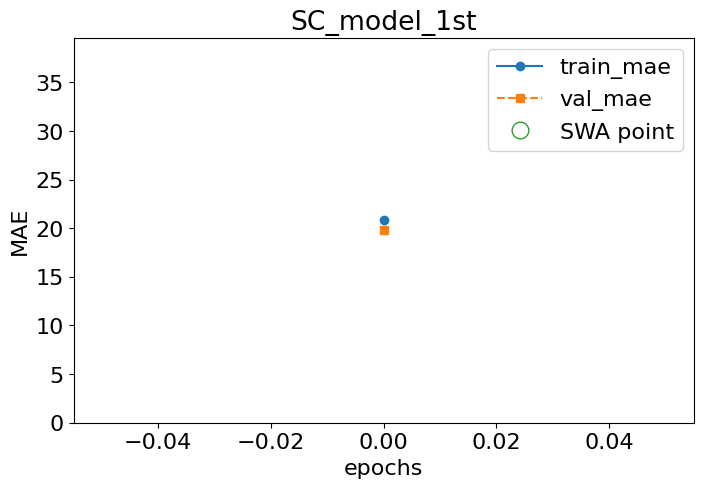

Epoch: 9/40 --- train mae: 8.13 val mae: 8.29


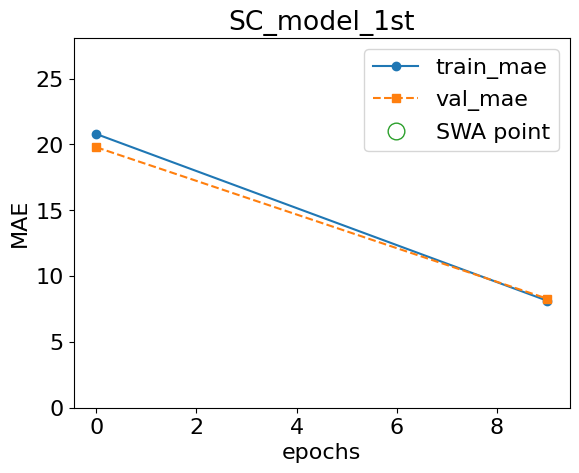

KeyboardInterrupt: 

In [11]:
cb.fit(train_df)#モデル訓練

y_pred, y_std, y_true,  = cb.predict(test_df = val_df, return_uncertainty = True, return_true = True)#原文ママではエラー　原因は出力が4つも出てこないということ、実際オプションでy_trueおよびy_stdを追加することは可能
#ただし、何もオプションを入れていない時点では、予測された結果値のみが出力される
#得られるstdは予測された値の標準偏差を示している
crabnet_dfs.append(#答えのファイルの作成
    pd.DataFrame(
        {
            "actual_Tc": y_true,
            "predicted_Tc": y_pred,
            "y_std": y_std,
            "formula": val_df["formula"],
        }
    )
)

In [29]:
crabnet_df = pd.concat(crabnet_dfs)

In [31]:
pd.set_option('display.max_rows', 1000)


In [32]:
display(crabnet_df)

,actual_Tc,predicted_Tc,y_std,formula
0,8.150000,9.675793,1.464750,Nb0.87Ta0.13
1,68.300003,78.308006,7.237195,La0.9Pr0.1Ba2Cu3O7
2,44.000000,70.703339,8.203346,Er1Ba2Cu2.79Zn0.03Fe0.18O6.97
3,3.800000,1.284300,1.075025,Bi1Pd1
8,19.549999,20.292179,1.864629,Ba0.5K0.5Bi1O3
26,4.500000,5.444546,2.316589,S1.1Zr1
29,6.000000,2.879007,1.033137,Rh0.53Se0.47
34,6.800000,16.526791,1.195685,Nb3Sn0.56Ge0.44
35,102.000000,99.186615,10.095751,Hg1Ba2Ca1Cu2O6.13
42,9.780000,24.074354,3.047585,Ca10Pt5Fe9As18
